<a href="https://colab.research.google.com/github/Anuradha-Ranathunga/COVID19_Virus-Detector/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! ls

sample_data


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download khoongweihao/covid19-xray-dataset-train-test-sets

Dataset URL: https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets
License(s): CC0-1.0
 82% 69.0M/84.3M [00:00<00:00, 109MB/s]
100% 84.3M/84.3M [00:00<00:00, 124MB/s]


In [ ]:
! unzip /content/covid19-xray-dataset-train-test-sets

Archive:  /content/covid19-xray-dataset-train-test-sets.zip
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0035-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0052-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0058-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0059-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0072-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0073-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0092-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0105-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0110-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0111-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0112-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0117-0001.jpeg  
  inflating: xray_dataset_covid19/test/NORMAL/NORMAL

In [ ]:
!pip install livelossplot
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 19.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2 as cv
from glob import glob
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKerasTF
import visualkeras

%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
mainDir = '/content/xray_dataset_covid19'

In [ ]:
mainDirList = os.listdir(mainDir)
mainDirList

['train', 'test']

In [ ]:
trainDir = mainDir + '/' + mainDirList[1]
testDir = mainDir + '/' + mainDirList[0]


print(f"Training directory : {trainDir}")
print(f"Testing directory : {testDir}")

Training directory : /content/xray_dataset_covid19/test
Testing directory : /content/xray_dataset_covid19/train


In [ ]:
outDir = '/content/output'

if not os.path.exists(outDir):
  os.mkdir(outDir)

figDir = outDir + "/fig"
if not os.path.exists(figDir):
  os.mkdir(figDir)

modelDir = outDir + "/model"
if not os.path.exists(modelDir):
  os.mkdir(modelDir)

In [ ]:
trainLabels = os.listdir(trainDir)
testLabels = os.listdir(testDir)

print(f"Training labels : {trainLabels}")
print()
print(f"Testing labels : {testLabels}")

Training labels : ['NORMAL', 'PNEUMONIA']

Testing labels : ['NORMAL', 'PNEUMONIA']


In [ ]:
def plotImgs(dir, labels, nrows, ncols):
  for label in labels:
    temp = dir + '/' + label
    temp = glob(temp + '/*')
    imgToPrint = np.random.choice(temp, size = nrows*ncols)
    plt.figure(figsize = (25, 25))
    for i in range(len(imgToPrint)):
      img = plt.imread(imgToPrint[i])
      plt.subplot(nrows, ncols, i + 1)
      plt.imshow(img, cmap = 'gray')
      plt.title(label)
      plt.grid('off')
      plt.axis('off')
    plt.savefig(figDir + f'/{label}')
  plt.show()

In [ ]:
for label in trainLabels:
  temp = trainDir + '/' + label
  print(temp)

/content/xray_dataset_covid19/test/NORMAL
/content/xray_dataset_covid19/test/PNEUMONIA


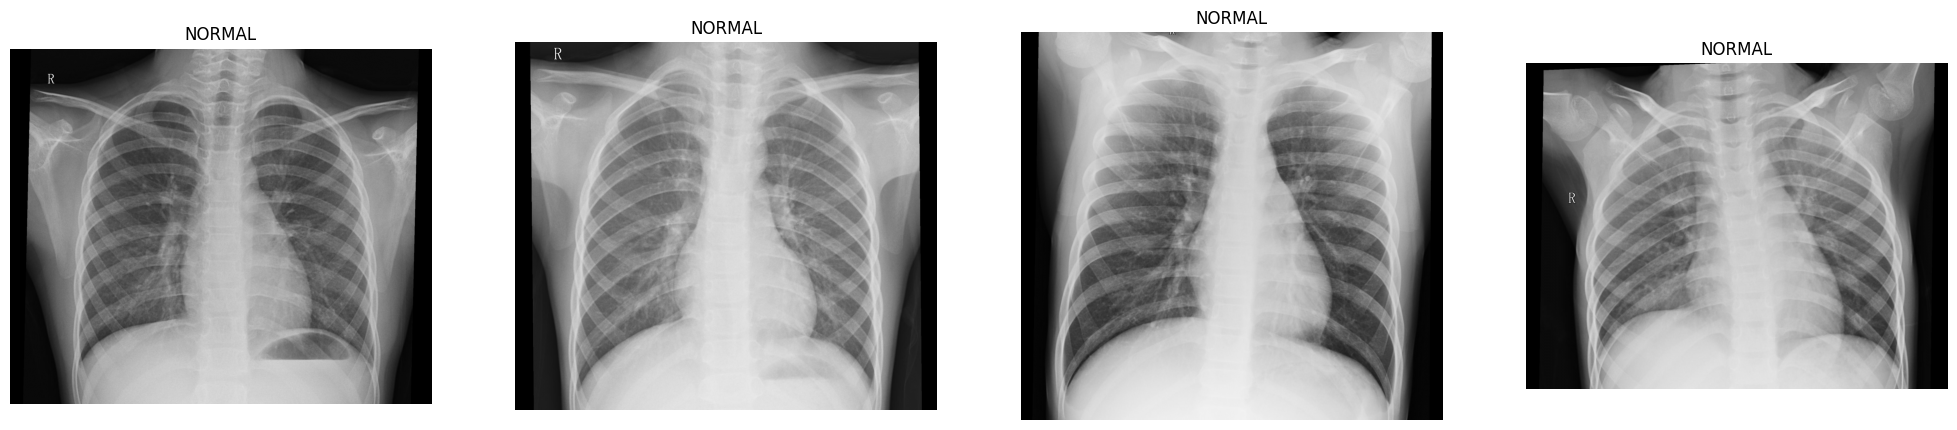

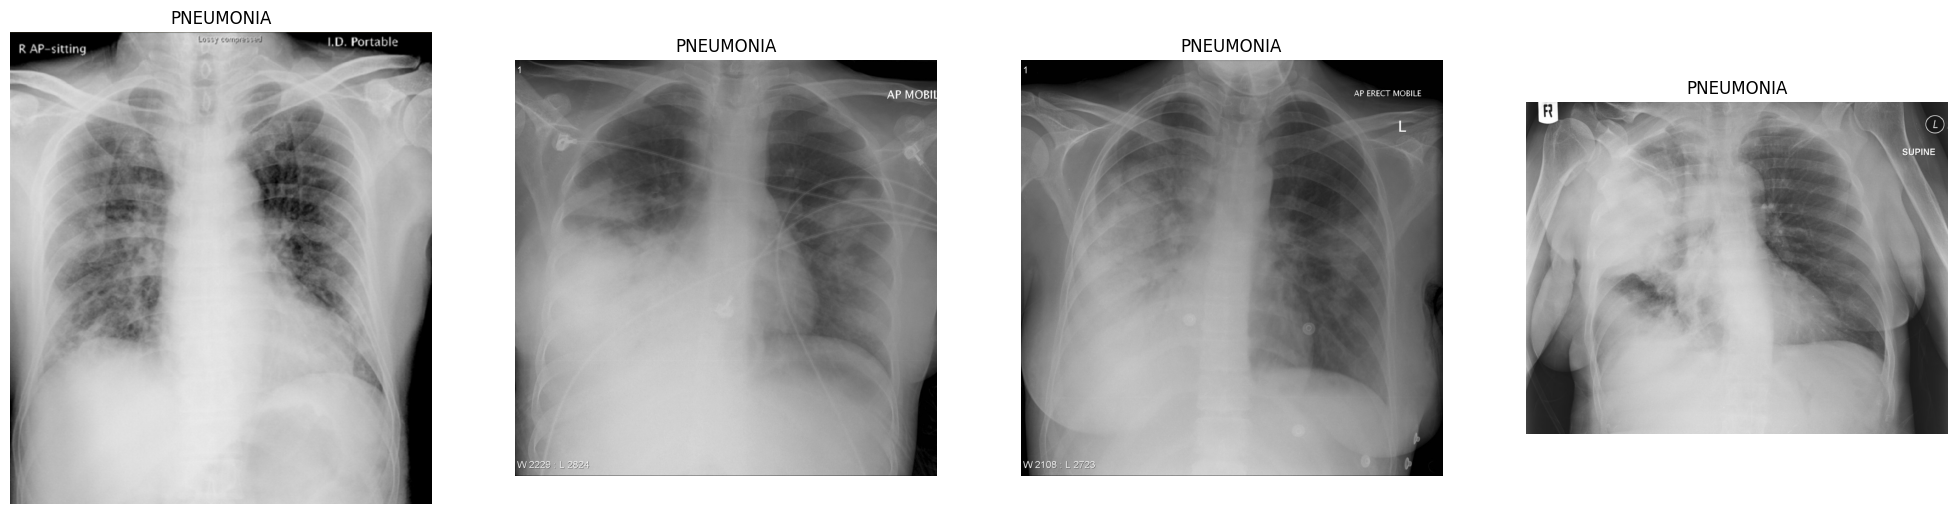

In [ ]:
plotImgs(trainDir, trainLabels, 1, 4)

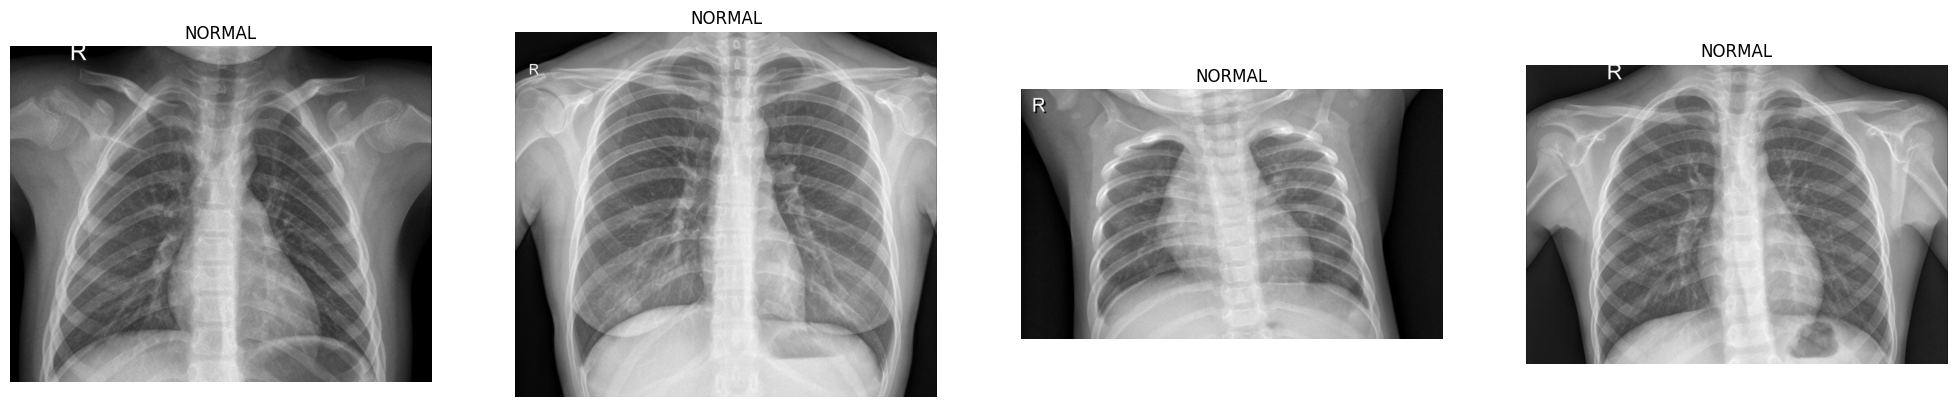

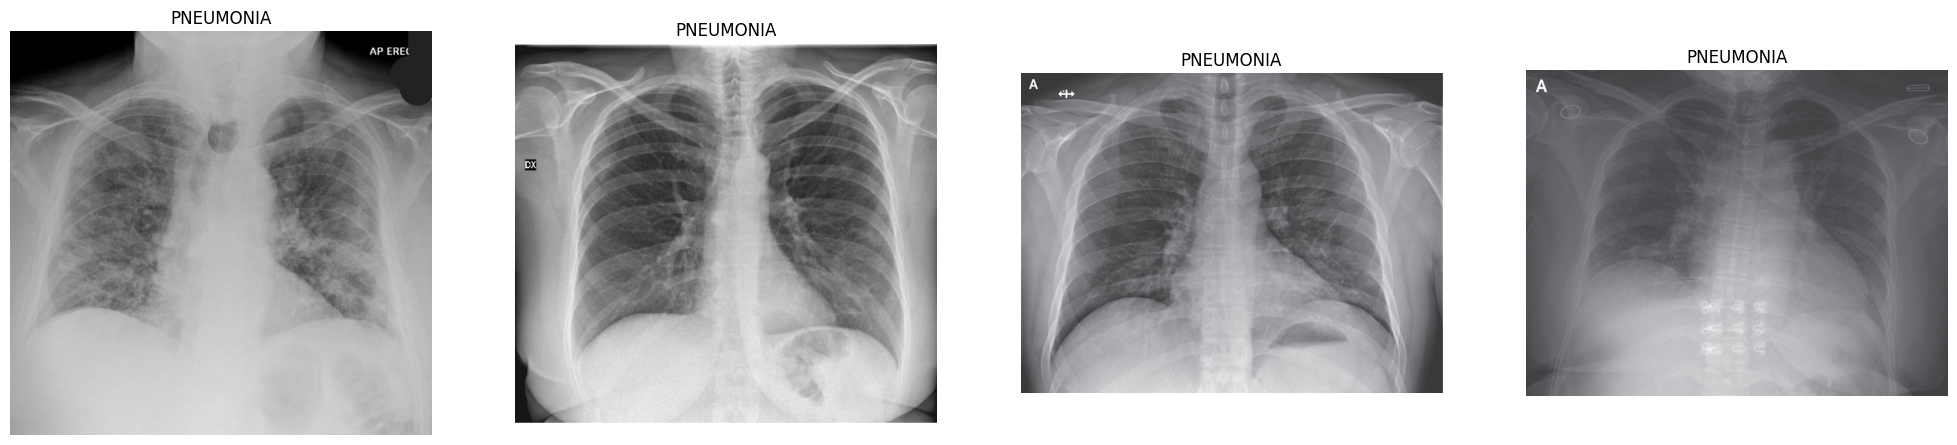

In [ ]:
plotImgs(testDir, testLabels, 1, 4)

In [ ]:
trainImgCount = {}
testImgCount = {}

def getImgCount(dir, labels, dic):
  for label in labels:
    temp = dir + '/' + label
    temp = glob(temp + '/*')
    dic[label] = len(temp)

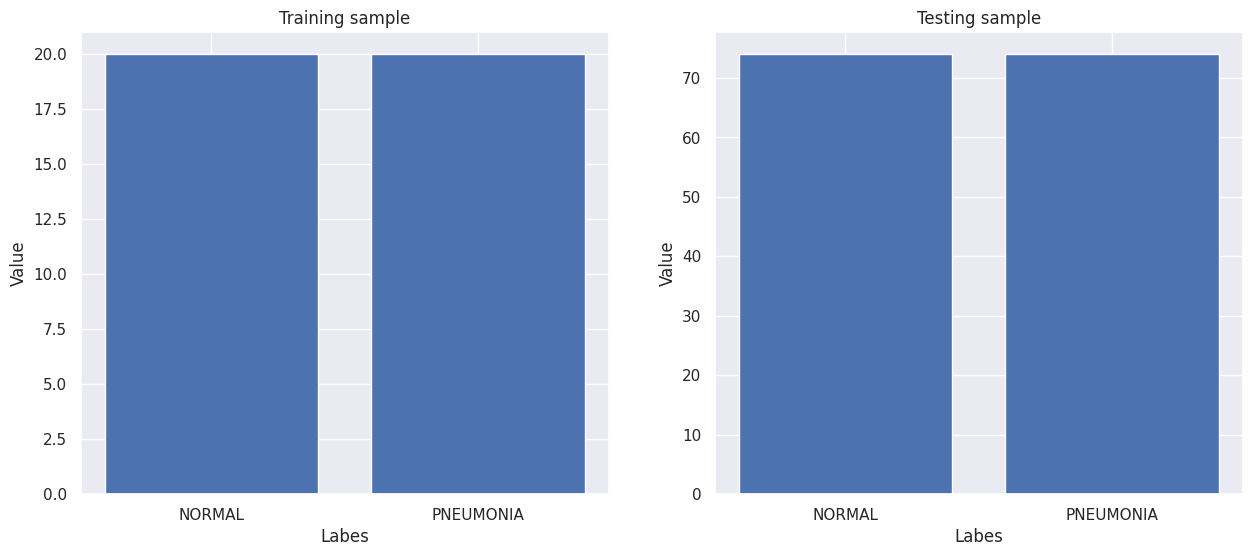

In [ ]:
sns.set()
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
getImgCount(trainDir, trainLabels, trainImgCount)
keys = trainImgCount.keys()
values = trainImgCount.values()
plt.bar(keys,values)
plt.xlabel('Labes')
plt.ylabel('Value')
plt.title('Training sample')
plt.savefig(figDir + f'/Training sample')


plt.subplot(1, 2, 2)
getImgCount(testDir, testLabels, testImgCount)
keys = testImgCount.keys()
values = testImgCount.values()
plt.bar(keys,values)
plt.xlabel('Labes')
plt.ylabel('Value')
plt.title('Testing sample')
plt.savefig(figDir + f'/Testing sample')


plt.show()

In [ ]:
targetSize = [124, 124]
inputSize = targetSize + [1]
outputSize = len(trainLabels)
batchSize = 25
rescale = 1./ 255
epochs = 100


trainGen = ImageDataGenerator(rescale=rescale,
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range=16,
                              validation_split =0.2)

testGen = ImageDataGenerator(rescale=rescale)


trainGenerator = trainGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize,
                                              shuffle = True,
                                              subset = 'training')

validGenerator = trainGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize,
                                              shuffle = True,
                                              subset = 'validation')

testGenerator = testGen.flow_from_directory(testDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize)

Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
stepsPertrainingEpoch = trainGenerator.n // trainGenerator.batch_size
stepsPerValidationEpoch = validGenerator.n // validGenerator.batch_size
stepsPerTestingEpoch = testGenerator.n // testGenerator.batch_size


print(f"Every training epoch has {stepsPertrainingEpoch} steps.")
print(f"Every training epoch has {stepsPertrainingEpoch} steps.")
print(f"Every testing epoch has {stepsPerTestingEpoch} steps.")

Every training epoch has 1 steps.
Every training epoch has 1 steps.
Every testing epoch has 5 steps.


In [ ]:
classIndices = trainGenerator.class_indices

print(f"Class Indices : {classIndices}")

outClass = {v : k for k, v in classIndices.items()}

print(f"Output classes : {outClass}")

Class Indices : {'NORMAL': 0, 'PNEUMONIA': 1}
Output classes : {0: 'NORMAL', 1: 'PNEUMONIA'}


In [ ]:
y = trainGenerator.classes

classWeight = class_weight.compute_class_weight(class_weight = 'balanced',classes= np.unique(y), y=y)

print(f"class weights : {classWeight}")

classWeights = {}

for i, j in enumerate(np.unique(y)):
  classWeights[j] = classWeight[i]

print(f"class weights for each class : {classWeights}")

class weights : [1. 1.]
class weights for each class : {0: 1.0, 1: 1.0}


In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint(modelDir + "/model_weights.weights.h5", # Changed the filepath to end with .weights.h5
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=inputSize))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(40, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(40, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(256, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units = 256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units = outputSize , activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 40)          │          11,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 40)          │          14,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 40)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 40)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 31, 40)          │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 31, 31, 64)          │          23,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 31, 31, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 128)           │             5

 Total params: 1,472,402 (5.62 MB)

 Trainable params: 1,468,802 (5.60 MB)

 Non-trainable params: 3,600 (14.06 KB)

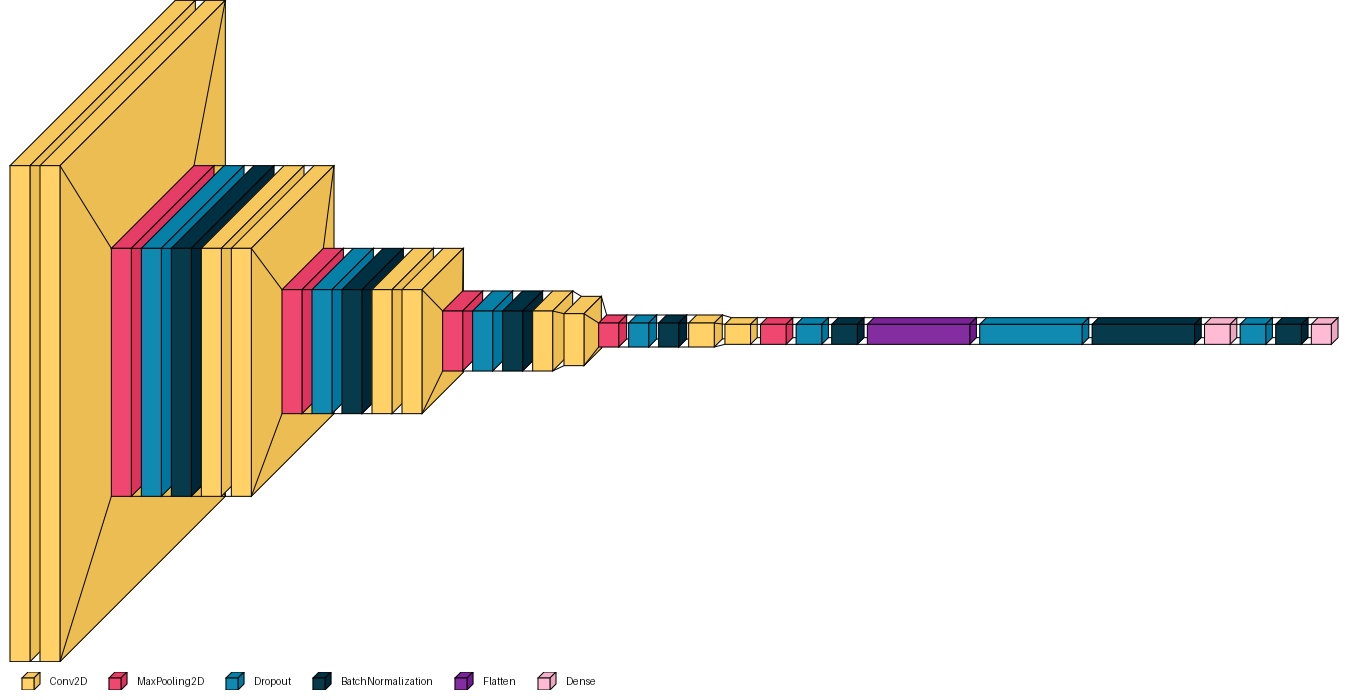

In [ ]:
visualkeras.layered_view(model, legend =True)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

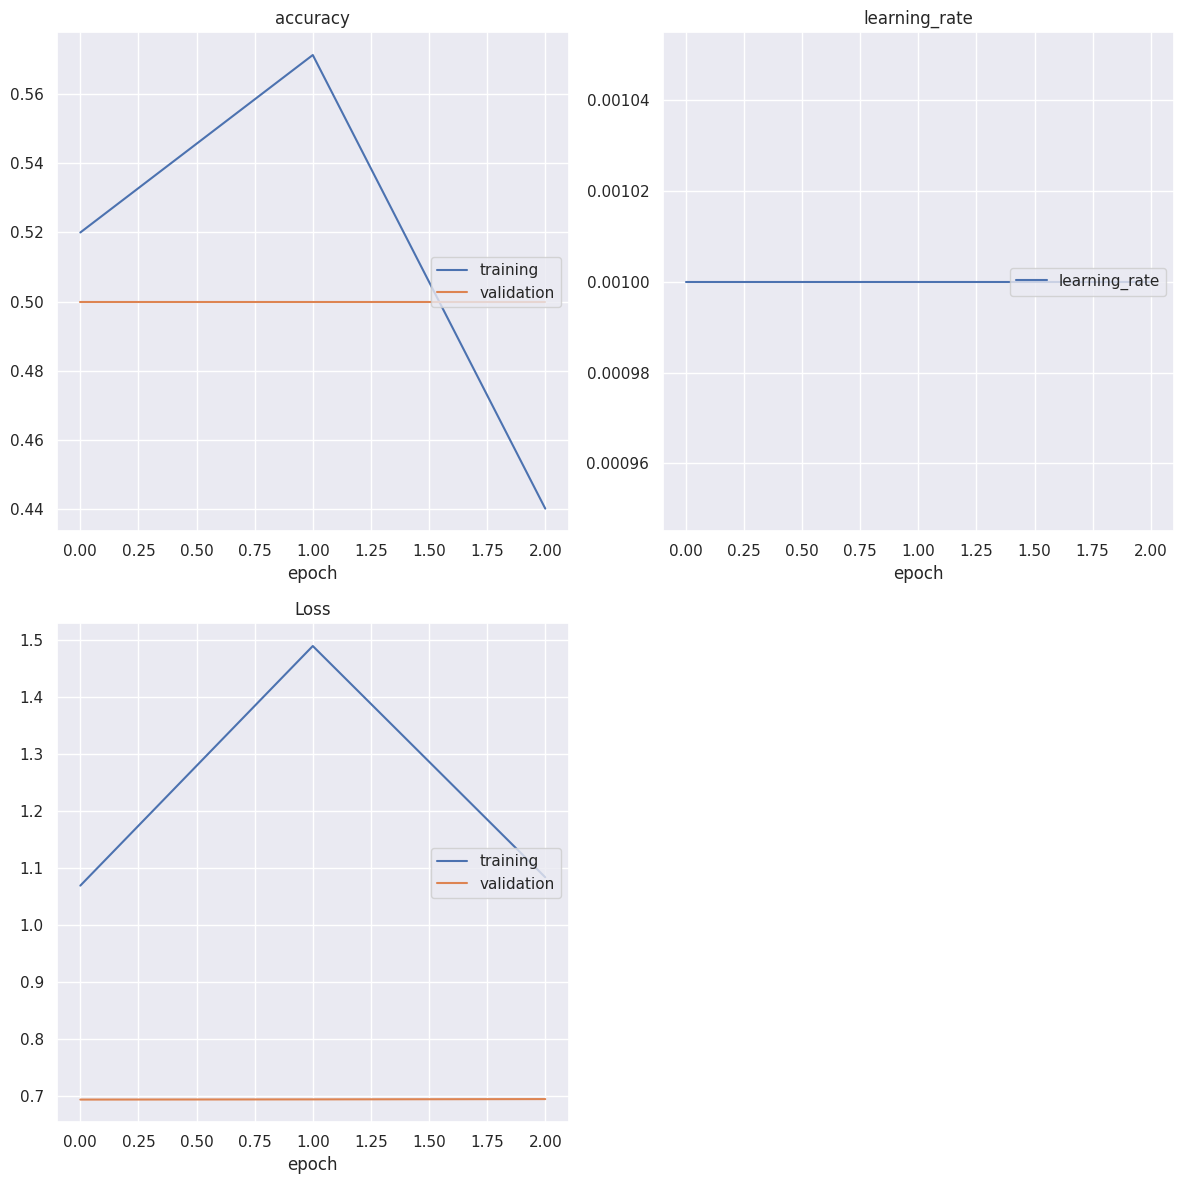

accuracy
	training         	 (min:    0.440, max:    0.571, cur:    0.440)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
learning_rate
	learning_rate    	 (min:    0.001, max:    0.001, cur:    0.001)
Loss
	training         	 (min:    1.069, max:    1.489, cur:    1.083)
	validation       	 (min:    0.693, max:    0.694, cur:    0.694)
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.4400 - loss: 1.0834 - val_accuracy: 0.5000 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 3: early stopping


In [ ]:
modelHist = model.fit(trainGenerator,
                        steps_per_epoch=stepsPertrainingEpoch,
                        epochs = epochs,
                        verbose=1,
                        callbacks=callBacks,
                        validation_data=validGenerator,
                        validation_steps=stepsPerValidationEpoch,
                        class_weight= classWeights,
                        # workers=-1, # Remove the 'workers' argument
                        # use_multiprocessing=True, # Remove the 'use_multiprocessing' argument
                        shuffle=True)